In [1]:
# импортируем необходимые функции из библиотеки
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

#Метрики качества R^2, MSE, MAE, MAPE и т.д
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volum

In [2]:
data2 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [3]:
data2.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
columns = ['traffic_volume', 'date_time', 'holiday', 'temp']
df2 = pd.DataFrame(data2, columns=columns)
df2.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [5]:
#Поищем дубликаты 
df2[df2.duplicated(keep=False)].head()

,traffic_volume,date_time,holiday,temp
178,6793,2012-10-10 07:00:00,None,281.25
179,6793,2012-10-10 07:00:00,None,281.25
180,6283,2012-10-10 08:00:00,None,280.10
181,6283,2012-10-10 08:00:00,None,280.10
182,5680,2012-10-10 09:00:00,None,279.61


In [6]:
#Удалим дубликаты
df2 = df2.drop_duplicates(keep='last')

2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха)

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40653 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  40653 non-null  int64  
 1   date_time       40653 non-null  object 
 2   holiday         40653 non-null  object 
 3   temp            40653 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


In [8]:
#Поищем дубликаты 
df2[df2.duplicated(keep=False)].head()

,traffic_volume,date_time,holiday,temp


In [9]:
df2.count()

traffic_volume    40653
date_time         40653
holiday           40653
temp              40653
dtype: int64

In [10]:
df2.set_index('date_time')

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,None,288.28
2012-10-02 10:00:00,4516,None,289.36
2012-10-02 11:00:00,4767,None,289.58
2012-10-02 12:00:00,5026,None,290.13
2012-10-02 13:00:00,4918,None,291.14
...,...,...,...
2018-09-30 19:00:00,3543,None,283.45
2018-09-30 20:00:00,2781,None,282.76
2018-09-30 21:00:00,2159,None,282.73


In [11]:
#Посмотрим пустые значения
df2.isnull().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html)

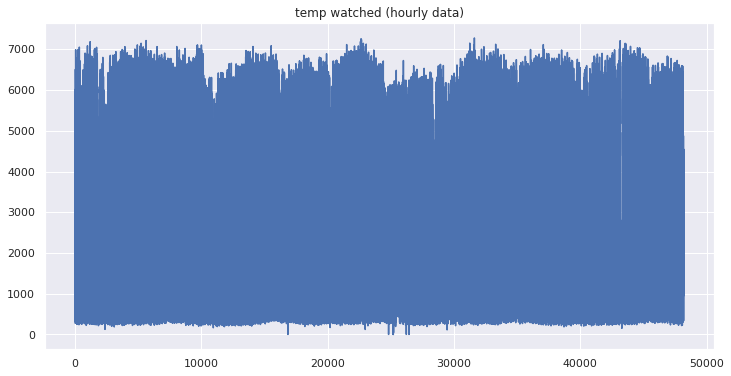

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df2.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

In [13]:
df2.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [14]:
df2.set_index('date_time',inplace=True)

In [15]:
df2.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,None,288.28
2012-10-02 10:00:00,4516,None,289.36
2012-10-02 11:00:00,4767,None,289.58
2012-10-02 12:00:00,5026,None,290.13
2012-10-02 13:00:00,4918,None,291.14


In [16]:
df2[df2.index.duplicated()]

,traffic_volume,holiday,temp
date_time,,,
2012-11-04 01:00:00,730,None,275.77
2014-01-03 20:00:00,2427,None,268.88
2014-01-09 16:00:00,6421,None,266.47
2014-01-11 16:00:00,4546,None,272.02
2014-01-15 00:00:00,515,None,259.14
...,...,...,...
2016-12-16 18:00:00,2344,None,261.65
2016-12-17 01:00:00,425,None,261.82
2016-12-18 14:00:00,3437,None,251.23


In [17]:
df4 = df2[~df2.index.duplicated()]

In [18]:
df4.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,None,288.28
2012-10-02 10:00:00,4516,None,289.36
2012-10-02 11:00:00,4767,None,289.58
2012-10-02 12:00:00,5026,None,290.13
2012-10-02 13:00:00,4918,None,291.14


In [19]:
df4.index = pd.to_datetime(df4.index)

In [20]:
df4.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=40575, freq=None)

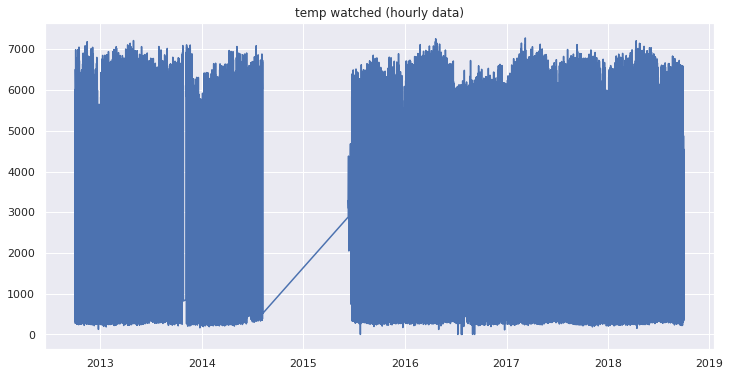

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df4.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

In [22]:
index = pd.date_range(start=df4.index.min(), end=df4.index.max(), freq='1H')

In [23]:
len(index)

52551

In [24]:
print(index)

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')


In [25]:
df_reindexed = df4.reindex(index)

In [26]:
df_reindexed.count()

traffic_volume    40575
holiday           40575
temp              40575
dtype: int64

In [27]:
df_reindexed.head()

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,None,288.28
2012-10-02 10:00:00,4516.0,None,289.36
2012-10-02 11:00:00,4767.0,None,289.58
2012-10-02 12:00:00,5026.0,None,290.13
2012-10-02 13:00:00,4918.0,None,291.14


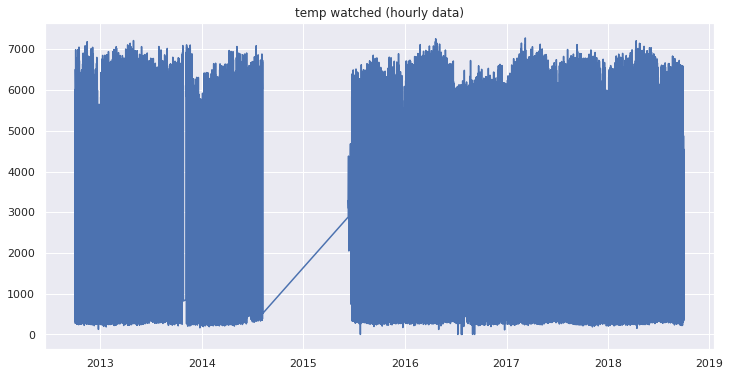

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df4.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

In [29]:
df_reindexed['traffic_volume'] = df_reindexed['traffic_volume'].interpolate(method='linear')
df_reindexed['holiday'] = df_reindexed['holiday'].interpolate(method='pad')
df_reindexed['temp'] = df_reindexed['temp'].interpolate(method='linear')

In [30]:
df_reindexed.isnull().sum()

traffic_volume    0
holiday           0
temp              0
dtype: int64

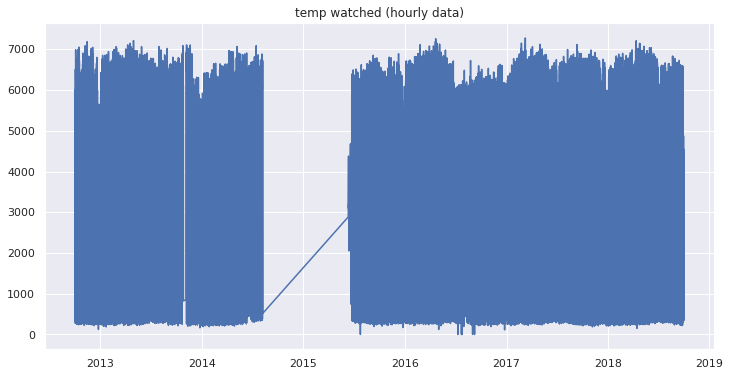

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df_reindexed.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

In [32]:
df_reindexed = df_reindexed[~df_reindexed.index.duplicated()]

In [33]:
df_reindexed.count()

traffic_volume    52551
holiday           52551
temp              52551
dtype: int64

In [34]:
df_reindexed.isnull().sum()

traffic_volume    0
holiday           0
temp              0
dtype: int64

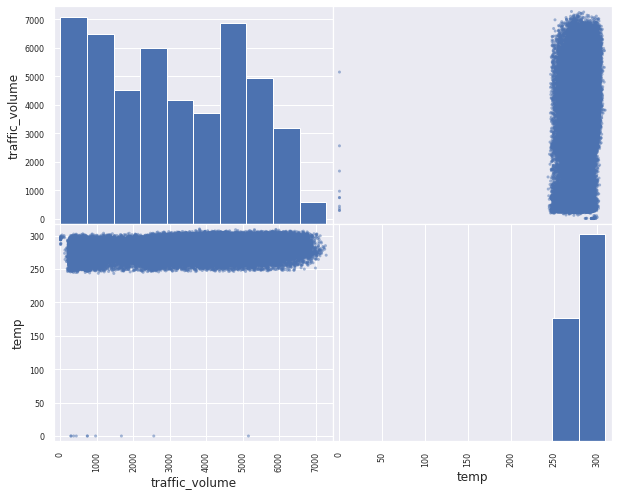

In [35]:
#Распределение трафика и температуры
num_vars = ['traffic_volume', 'temp']
from pandas.plotting import scatter_matrix
scatter_matrix(df_reindexed[num_vars],figsize=(10,8))
plt.show()

<Figure size 720x576 with 0 Axes>

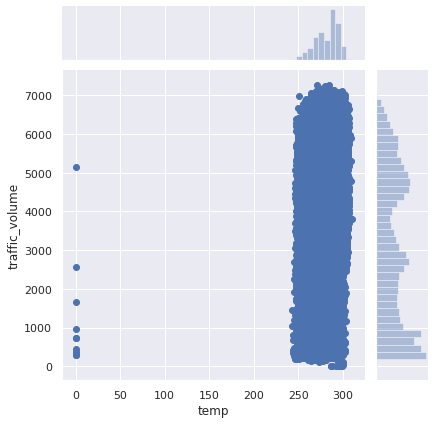

In [36]:
#график зависимости температуры от интенсивности движения
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.jointplot(y='traffic_volume', x='temp', data = df_reindexed.loc[df_reindexed.temp>-50])
plt.show()

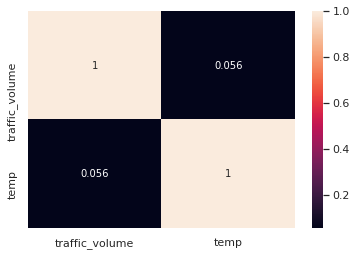

In [37]:
#корреляция для числовых переменных
sns.heatmap(df_reindexed.corr(), annot=True)
plt.show()

Feature engineering and Data cleaning

In [38]:
df_traffic_features = df_reindexed.copy()

In [39]:
#Уберем выброс
df_traffic_features = df_traffic_features.loc[df_traffic_features.temp>-250]

In [40]:
df_traffic_features.head()

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,None,288.28
2012-10-02 10:00:00,4516.0,None,289.36
2012-10-02 11:00:00,4767.0,None,289.58
2012-10-02 12:00:00,5026.0,None,290.13
2012-10-02 13:00:00,4918.0,None,291.14


In [41]:
df_traffic_features['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [42]:
#работа с категориальными переменными (dummy)
def modify_holiday(x):
    if x == 'None':
        return 0
    else:
        return 1
df_traffic_features['holiday'] = df_traffic_features['holiday'].map(modify_holiday)

In [43]:
df_traffic_features.head()

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,0,288.28
2012-10-02 10:00:00,4516.0,0,289.36
2012-10-02 11:00:00,4767.0,0,289.58
2012-10-02 12:00:00,5026.0,0,290.13
2012-10-02 13:00:00,4918.0,0,291.14


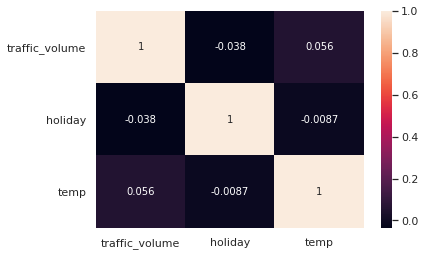

In [44]:
#корреляция для числовых переменных
sns.heatmap(df_traffic_features.corr(), annot=True)
plt.show()

In [45]:
df_traffic_features.index.max()

Timestamp('2018-09-30 23:00:00', freq='H')

In [46]:
df_traffic_features.index.min()

Timestamp('2012-10-02 09:00:00', freq='H')

3. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня

In [47]:
df_traffic_features.head()

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,0,288.28
2012-10-02 10:00:00,4516.0,0,289.36
2012-10-02 11:00:00,4767.0,0,289.58
2012-10-02 12:00:00,5026.0,0,290.13
2012-10-02 13:00:00,4918.0,0,291.14


1. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек

Моделирование
Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд). 

Вопрос: Вот тут мне не понятно зачем мы для теста откладываем две недели, если должны предсказывать одну? Поэтому я отложу одну

In [48]:
y_test = pd.DataFrame(df_traffic_features['2018-09-24 00:00:00':].traffic_volume.copy())
X_test = pd.DataFrame(df_traffic_features['2018-09-24 00:00:00':].copy()).drop(['traffic_volume'], axis=1)

In [49]:
y_test.count()

traffic_volume    168
dtype: int64

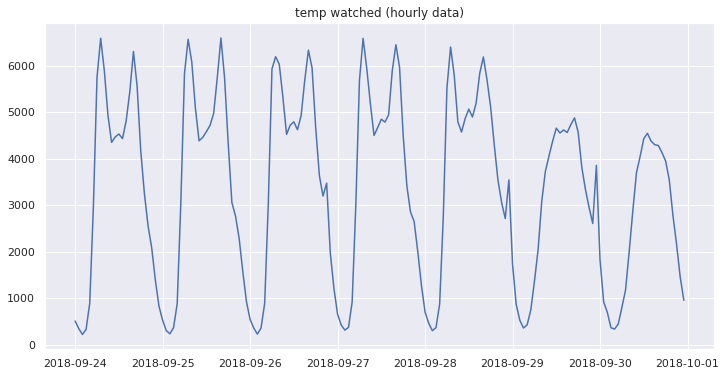

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

2. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть

In [51]:
y_train = pd.DataFrame(df_traffic_features['2018-08-27 00:00:00': '2018-09-24 00:00:00'].traffic_volume.copy())
X_train = pd.DataFrame(df_traffic_features['2018-08-27 00:00:00': '2018-09-24 00:00:00'].copy()).drop(['traffic_volume'], axis=1)

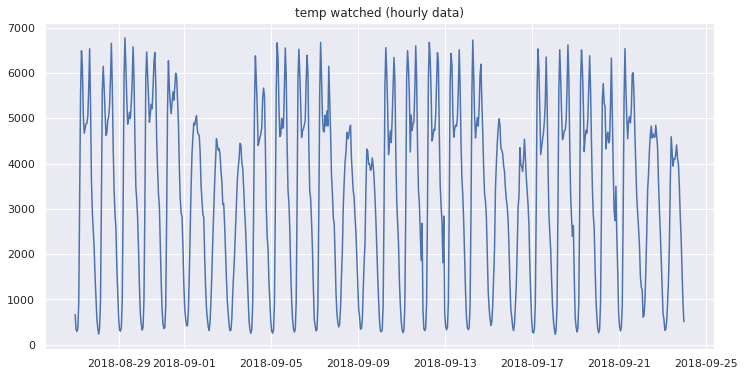

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.traffic_volume)
plt.title('temp watched (hourly data)')
plt.grid(True)
plt.show()

In [53]:
X_train['weekday'] = X_train.index.weekday
X_train['hour'] = X_train.index.hour

In [54]:
X_train.isna().sum()

holiday    0
temp       0
weekday    0
hour       0
dtype: int64

In [55]:
X_train.index.min()

Timestamp('2018-08-27 00:00:00', freq='H')

4. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными

In [56]:
df_baseline = pd.DataFrame(y_train["traffic_volume"].copy())
df_baseline['weekday'] = y_train.index.weekday
df_baseline['hour'] = y_train.index.hour

In [57]:
baseline = df_baseline.groupby(["weekday", "hour"])["traffic_volume"].mean()

In [58]:
baseline.count()

168

In [59]:
print(baseline)

weekday  hour
0        0        644.20
         1        403.50
         2        314.75
         3        335.25
         4        749.75
                  ...   
6        19      3318.00
         20      2952.00
         21      2444.50
         22      1740.00
         23      1123.25
Name: traffic_volume, Length: 168, dtype: float64


Посчитайте метрики качества, которые вы посчитаете нужными

In [60]:
# подгружаем метрики
#метрики качества (можно взять несколько, R2, MAE, RMSE)
#Средняя абсолютная ошибка (MAE) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными посредством усредненной абсолютной разницы по набору данных.
#Среднеквадратическая ошибка (RMSE) это частота ошибок, вычисляемая квадратным корнем из MSE.
#Коэффициент детерминации (R2) - описявает качество модели. Чем выше значение, тем лучше модель (от 0 до 1, 1 идеальный)
#Средняя абсолютнаяпроцентная ошибка (MAPE) - процент кол-ва ошибок
#Среднеквадратическая ошибка (MSE) - представляет собой разницу между исходным и прогнозируемым значениями, извлеченными путем возведения в квадрат средней разницы по набору данных.
from sklearn import metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [61]:
y_pred_naive = np.ones(len(y_test)) * baseline  # спрогнозировали им цену всех квартир в тестовой выборке
measured_metrics["y_pred_naive"] = dataframe_metrics(y_test, y_pred_naive)
measured_metrics

,error_type,y_pred_naive
0,MAE,193.545833
1,RMSE,318.726947
2,R2,0.974278
3,MAPE,193.549207


5. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.

### SARIMA

In [62]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [63]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

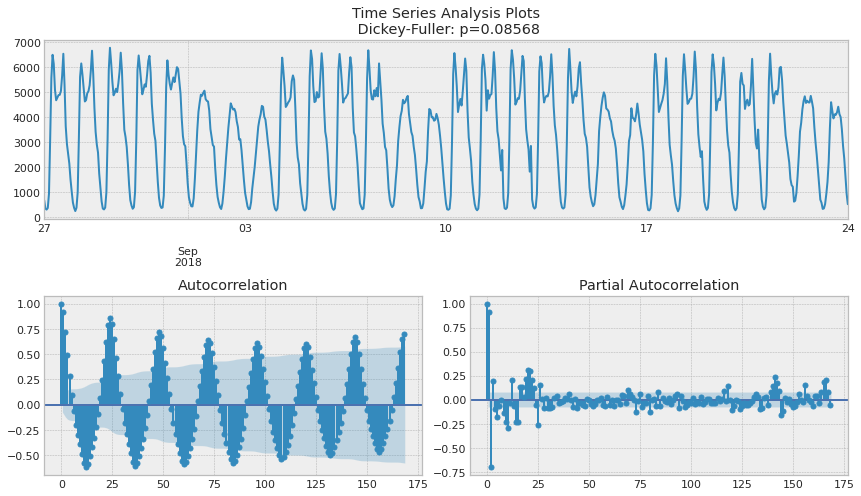

In [64]:
tsplot(y_train.traffic_volume, lags=168)

ряд по критерию Дикки-Фуллера стационарен, по его графику тоже видно, что тренд, как таковой, отсутствует, т.е., матожидание постоянно, разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается

Косинусойда - сезонность, с которой нужно разобраться перед построением модели. Для этого выполним преобразование под хитрым названием "сезонное дифференцирование", под которым скрывается простое вычитание из ряда самого себя с лагом равным периоду сезонности. В нашем случает 24*7=168 часа

In [65]:
season = 168

In [66]:
y_train.count()

traffic_volume    673
dtype: int64

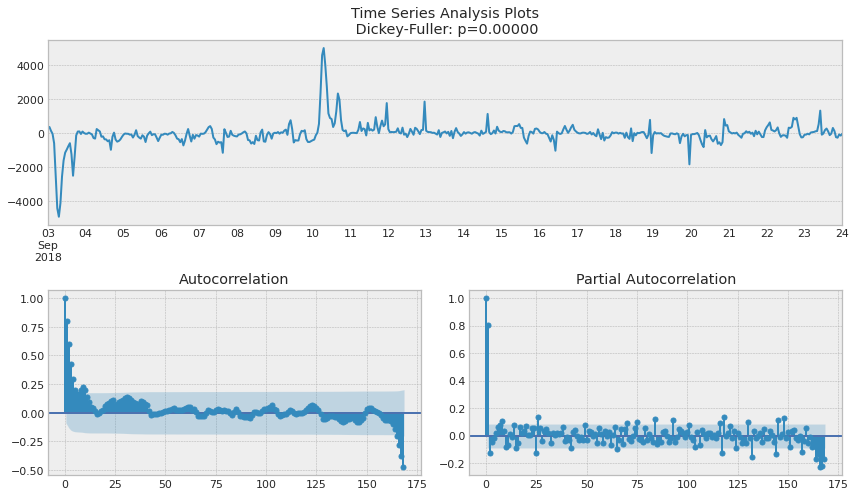

In [67]:
y_train_season = y_train.traffic_volume - y_train.traffic_volume.shift(season)
tsplot(y_train_season[season:], lags=season)

Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

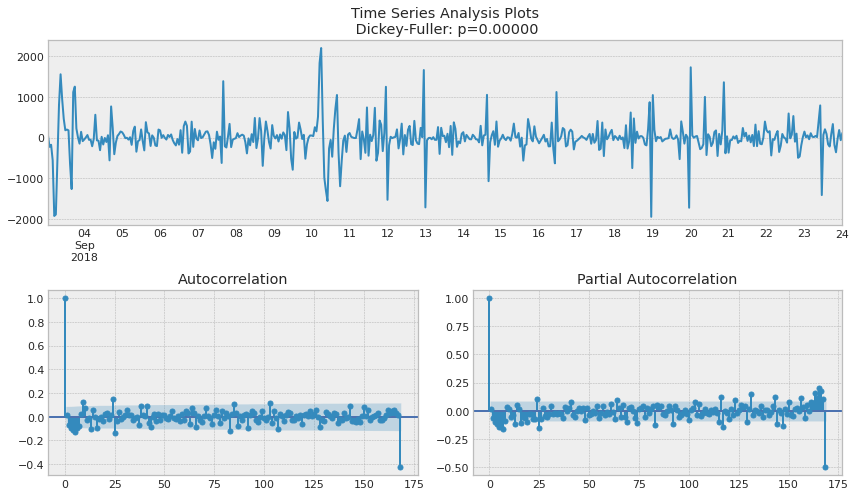

In [68]:
y_train_shift = y_train_season - y_train_season.shift(1)
tsplot(y_train_shift[season+1:], lags=season)

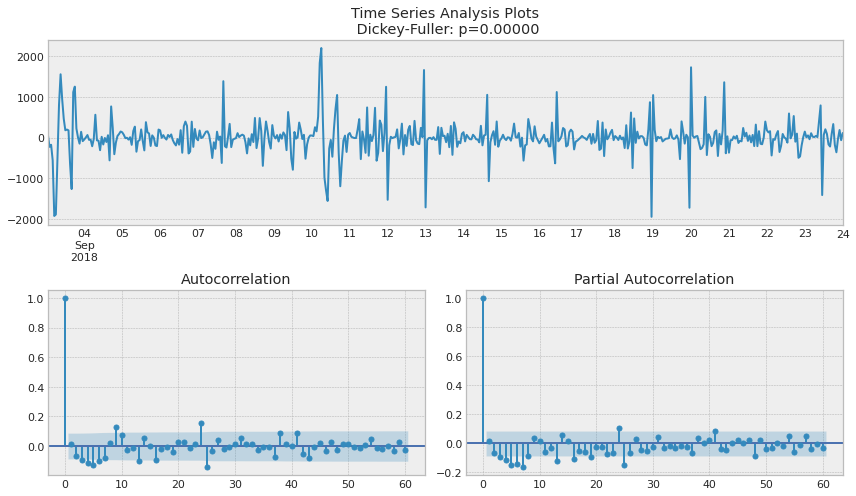

In [69]:
tsplot(y_train_shift[season+1:], lags=60)

теперь ряд выглядит как непонятно что, колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию!

𝐴𝑅(𝑝)  - модель авторегрессии (Смотрим значимые лаги в Partial Autocorrelation)
𝑀𝐴(𝑞)  - модель скользящего среднего (Смотрим значимые лаги в Autocorrelation)
𝐴𝑅(𝑝)+𝑀𝐴(𝑞)=𝐴𝑅𝑀𝐴(𝑝,𝑞)
𝐼(𝑑)  - порядок интегрированности временного ряда (Кол-во не сезонных разностей)
𝑆(𝑠)  - эта буква отвечает за сезонность и равна длине периода сезонности во временном ряде
𝑃  - порядок модели авторегрессии для сезонной компоненты, определяется по PACF, смотреть нужно на число значимых лагов (Смотрим кол-во значемых лагов кратные сезонности в Partial Autocorrelation)
𝑄  - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF (Смотрим кол-во значемых лагов кратные сезонности в Autocorrelation)
𝐷  - порядок сезонной интегрированности временного ряда. (Кол-во сезонных диференцирований)

Подбор параметров модель будет лучше

In [70]:
# setting initial values and some bounds for them
ps = [7, 25]
d=1 
qs = [6, 25]
Ps = [1,2]
D=1 
Qs = [1]
s = 24*7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [71]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y_train.traffic_volume, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [72]:
# На моем компьютере за ночь не смогло расчитаться, поэтому закоментировано. 
#Считала для сезоности дни, расчитывалось. 
%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [73]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]
#p, q, P, Q = [7,6,2,1]
best_model=sm.tsa.statespace.SARIMAX(y_train.traffic_volume, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

Посмотрим на остатки модели:

In [74]:
tsplot(best_model.resid[24*7+1:], lags=168)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [75]:
def plotSARIMA(series, model, n_steps, s=24*7, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

In [76]:
#plotSARIMA(y_test, best_model, 168, alpha=0.5)

В финале получаем очень хороший прогноз, заказчику средняя абсолютная ошибка в 6 процента также наверняка понравится, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

### Лаги временного ряда

Сдвигая ряд на  𝑛  шагов мы получаем столбец-признак, в котором текущему значению ряда в момент  𝑡  будет соответствовать его значение в момент времени  𝑡−𝑛 . Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 14 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 14 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходиться балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлимым качеством предсказания

In [77]:
data_copy = pd.DataFrame(df_traffic_features['2018-07-24 00:00:00': '2018-09-30 23:00:00'].copy())
data_copy.drop(["holiday", "temp"], axis=1, inplace=True)

In [78]:
data_copy.columns

Index(['traffic_volume'], dtype='object')

In [79]:
data_copy.head()

,traffic_volume
2018-07-24 00:00:00,638.0
2018-07-24 01:00:00,391.0
2018-07-24 02:00:00,297.0
2018-07-24 03:00:00,390.0
2018-07-24 04:00:00,891.0


In [80]:
data_copy.tail()

,traffic_volume
2018-09-30 19:00:00,3543.0
2018-09-30 20:00:00,2781.0
2018-09-30 21:00:00,2159.0
2018-09-30 22:00:00,1450.0
2018-09-30 23:00:00,954.0


In [81]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data_copy["lag_{}".format(i)] = data_copy.traffic_volume.shift(i)

In [82]:
# take a look at the new dataframe 
data_copy.head(25)

,traffic_volume,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
2018-07-24 00:00:00,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 01:00:00,391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 02:00:00,297.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 03:00:00,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 04:00:00,891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 05:00:00,3184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 06:00:00,5782.0,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 07:00:00,6409.0,391.0,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 08:00:00,5658.0,297.0,391.0,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-24 09:00:00,4984.0,390.0,297.0,391.0,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
data_copy = data_copy.dropna()

In [84]:
# take a look at the new dataframe 
data_copy.head(25)

,traffic_volume,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
2018-07-25 00:00:00,664.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0,391.0,638.0
2018-07-25 01:00:00,388.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0,391.0
2018-07-25 02:00:00,290.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0
2018-07-25 03:00:00,372.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0
2018-07-25 04:00:00,955.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0
2018-07-25 05:00:00,3121.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0
2018-07-25 06:00:00,5926.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0
2018-07-25 07:00:00,6595.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0
2018-07-25 08:00:00,5651.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0
2018-07-25 09:00:00,4974.0,372.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0


In [85]:
data_copy.shape

(1632, 20)

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [87]:
# Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю.
# Отложим неделю на тест
def timeseries_train_test_split(X, y, test_index):
    """
        Perform train-test split with respect to time series structure
    """
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    
    return X_train, X_test, y_train, y_test

In [88]:
y = data_copy.dropna().traffic_volume
X = data_copy.dropna().drop(['traffic_volume'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, -24*7)

In [89]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [90]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

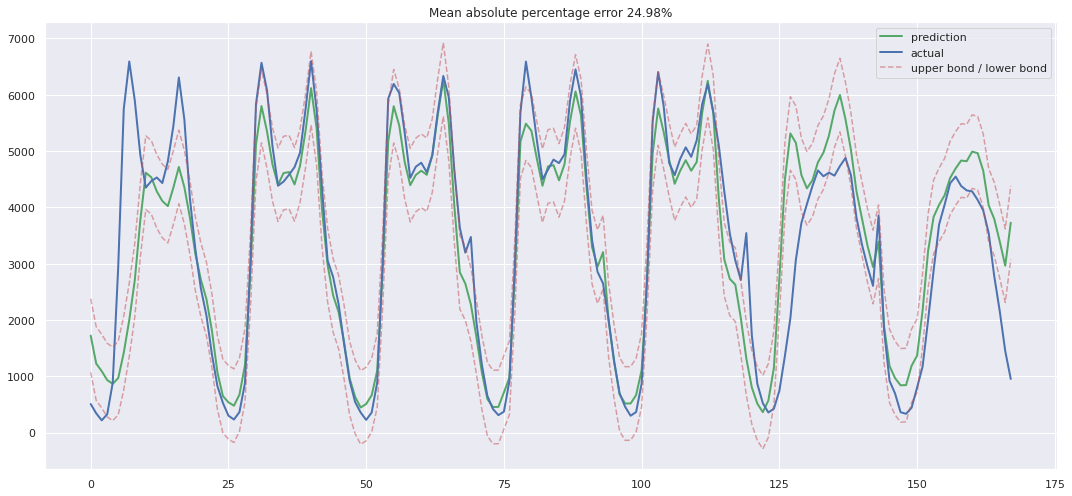

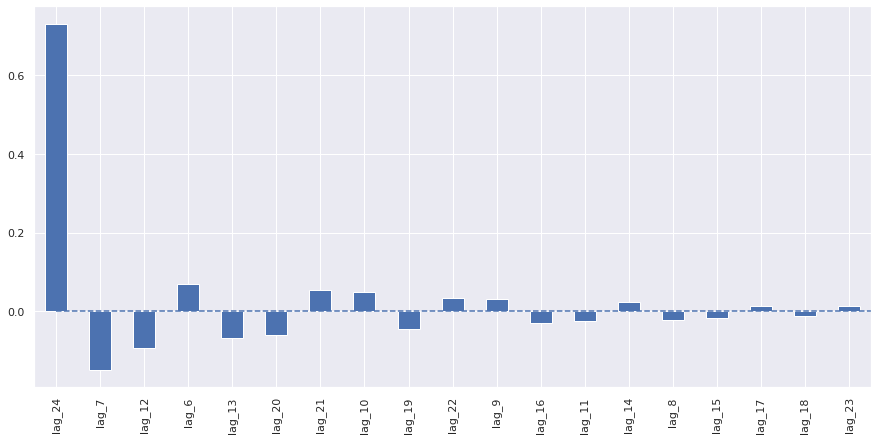

In [91]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Большая ошибка, добавим признаков и прошкалируем

In [92]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [93]:
def cycle_data_encoding(df, cycle, name):
    df['sin_' + name] = np.sin(2*np.pi*df[name]/cycle)
    df['cos_' + name] = np.cos(2*np.pi*df[name]/cycle)

    return df

In [94]:
def prepareData(series, lag_start, lag_end, test_index, target_encoding=False, circle_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
            
        get_dummies: boolean
            if True - encode categorical into dummies
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["traffic_volume"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.traffic_volume.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    if target_encoding:
        # calculate averages on train set only
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "traffic_volume").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "traffic_volume").get, data.hour))
    if circle_encoding:
        data = cycle_data_encoding(data, 24, 'hour')
        data = cycle_data_encoding(data, 7, 'weekday')
        # drop encoded variables 
    if circle_encoding or target_encoding:
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().traffic_volume
    X = data.dropna().drop(['traffic_volume'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_index)

    return X_train, X_test, y_train, y_test

In [95]:
data_copy.head(10)

,traffic_volume,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
2018-07-25 00:00:00,664.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0,391.0,638.0
2018-07-25 01:00:00,388.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0,391.0
2018-07-25 02:00:00,290.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0,297.0
2018-07-25 03:00:00,372.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0,390.0
2018-07-25 04:00:00,955.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0,891.0
2018-07-25 05:00:00,3121.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0,3184.0
2018-07-25 06:00:00,5926.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0,5782.0
2018-07-25 07:00:00,6595.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0,6409.0
2018-07-25 08:00:00,5651.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0,5658.0
2018-07-25 09:00:00,4974.0,372.0,290.0,388.0,664.0,1269.0,2178.0,2727.0,3266.0,3371.0,4430.0,5636.0,6558.0,5699.0,4944.0,4664.0,4805.0,4634.0,4386.0,4984.0


In [96]:
X_train, X_test, y_train, y_test =\
prepareData(data_copy.traffic_volume, lag_start=6, lag_end=25, test_index=-24*7, target_encoding=False, circle_encoding=True)

column_to_scale = [col for col in X_train.columns if 'lag' in col]
X_train_scaled = scaler.fit_transform(X_train[column_to_scale])
X_test_scaled = scaler.transform(X_test[column_to_scale])

X_train[column_to_scale] = X_train_scaled
X_test[column_to_scale] = X_test_scaled

In [97]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_20,lag_21,lag_22,lag_23,lag_24,is_weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
2018-07-26 00:00:00,0.569547,1.419887,1.706477,1.270938,0.861128,0.772019,0.740303,0.781363,0.608859,0.828764,...,-1.249021,-1.549318,-1.591100,-1.539665,-1.396407,0,0.000000,1.000000,0.433884,-0.900969
2018-07-26 01:00:00,0.060225,0.568599,1.417654,1.704981,1.270344,0.860649,0.771732,0.740148,0.780914,0.607798,...,-0.132488,-1.248823,-1.548844,-1.590145,-1.538511,0,0.258819,0.965926,0.433884,-0.900969
2018-07-26 02:00:00,-0.156727,0.059581,0.567173,1.416306,1.704298,1.269793,0.860353,0.771575,0.739703,0.779832,...,1.313439,-0.132405,-1.248413,-1.547907,-1.588968,0,0.500000,0.866025,0.433884,-0.900969
2018-07-26 03:00:00,-0.146913,-0.157242,0.058638,0.566261,1.415683,1.703671,1.269448,0.860188,0.771126,0.738626,...,1.658297,1.313372,-0.132233,-1.247598,-1.546749,0,0.707107,0.707107,0.433884,-0.900969
2018-07-26 04:00:00,-0.482673,-0.147433,-0.157979,0.057987,0.565813,1.415106,1.703275,1.269254,0.859729,0.770046,...,1.171682,1.658194,1.313235,-0.131871,-1.246581,0,0.866025,0.500000,0.433884,-0.900969


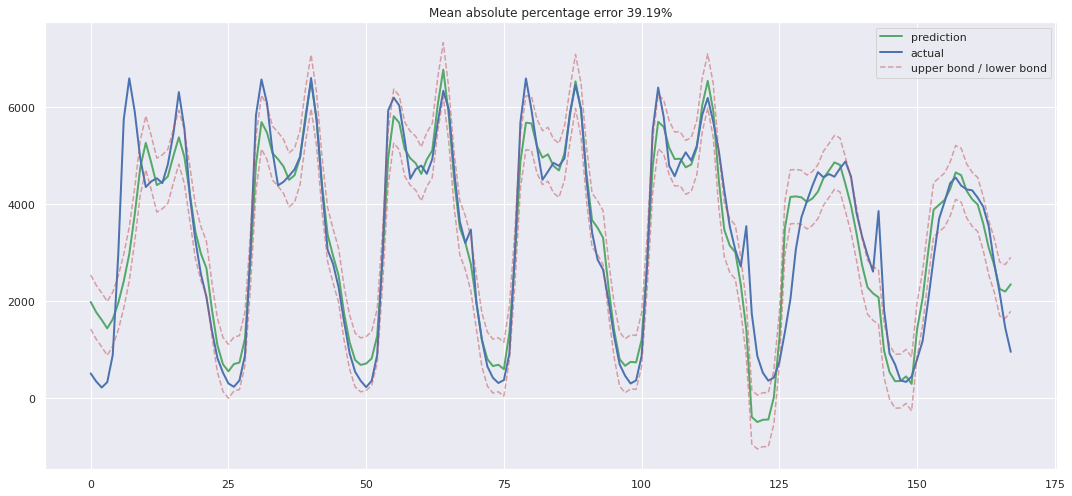

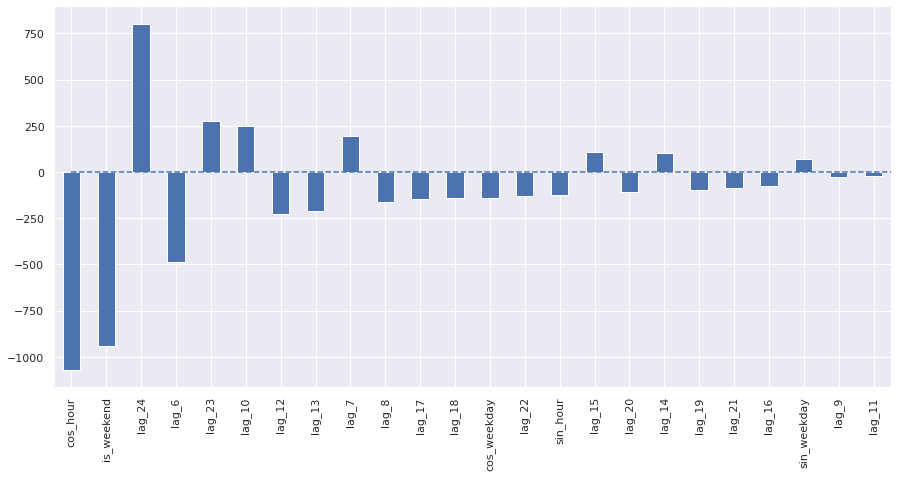

In [98]:
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True)
plotCoefficients(lr)

кодировать часы и недели c помощию синусов и косинусов

### Регуляризация и отбор признаков

Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень много скоррелированных признаков

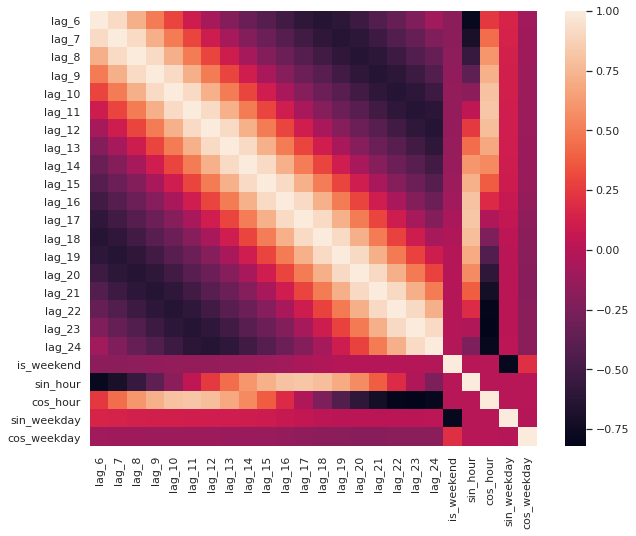

In [99]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

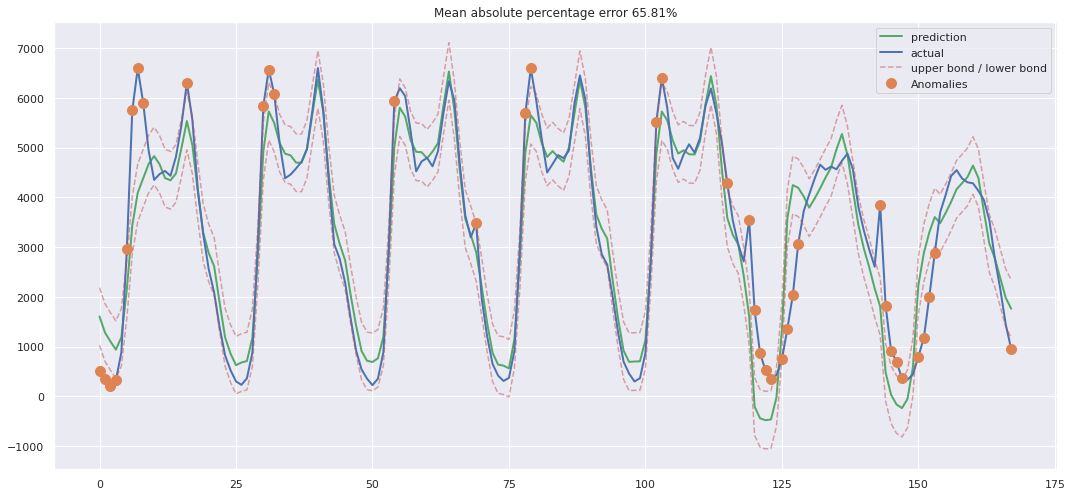

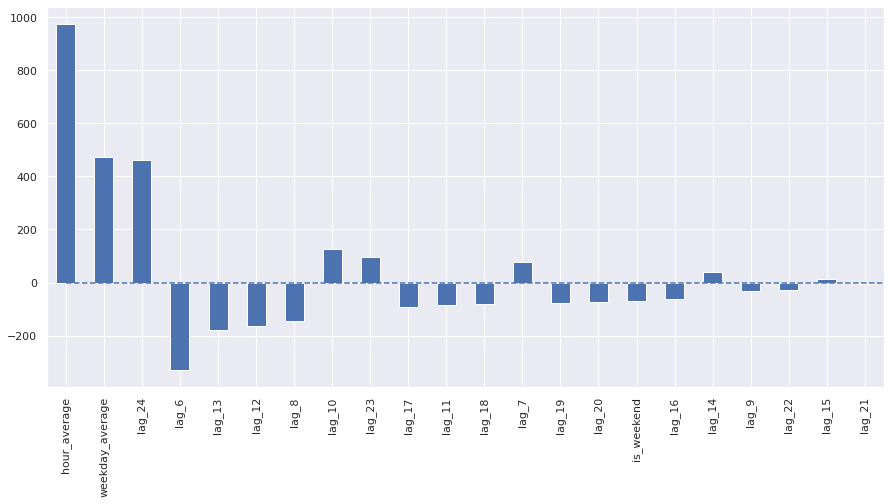

In [100]:
X_train, X_test, y_train, y_test =\
prepareData(data_copy.traffic_volume, lag_start=6, lag_end=25, test_index=-24*7, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

Переобучение, переменные average настолько понравились нашей модели на тренировочном датасете, что по ней, в основном, модель и стала прогнозировать. 

### Регуляризация и отбор признаков

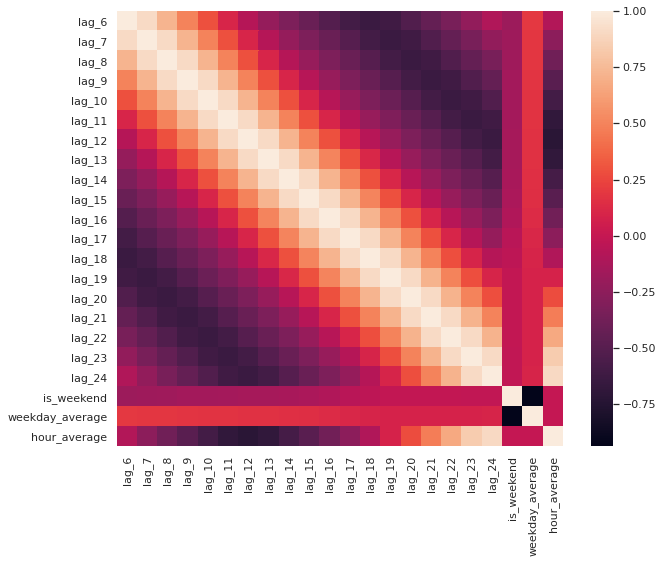

In [101]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

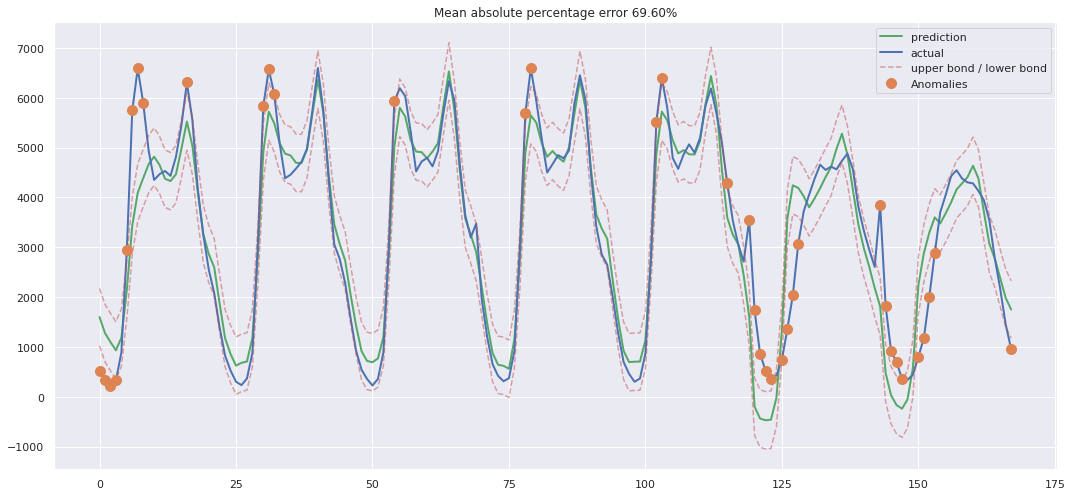

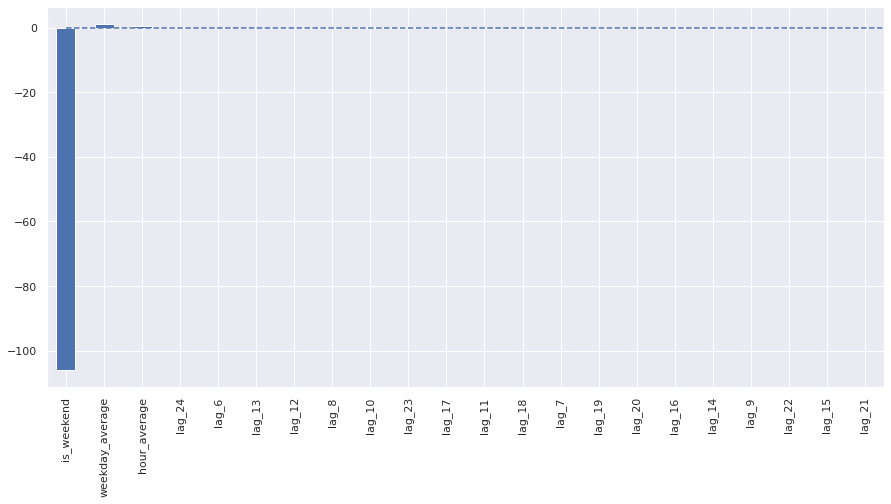

In [102]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

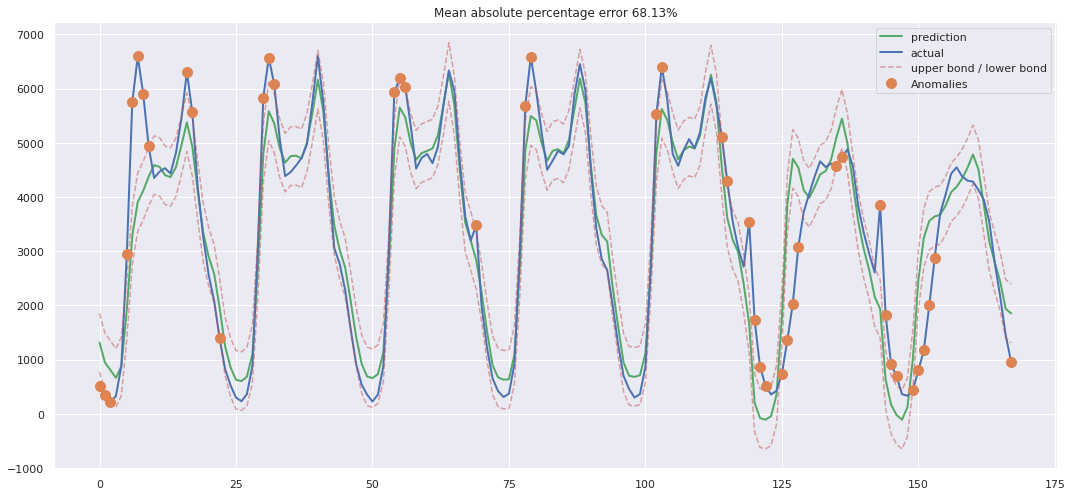

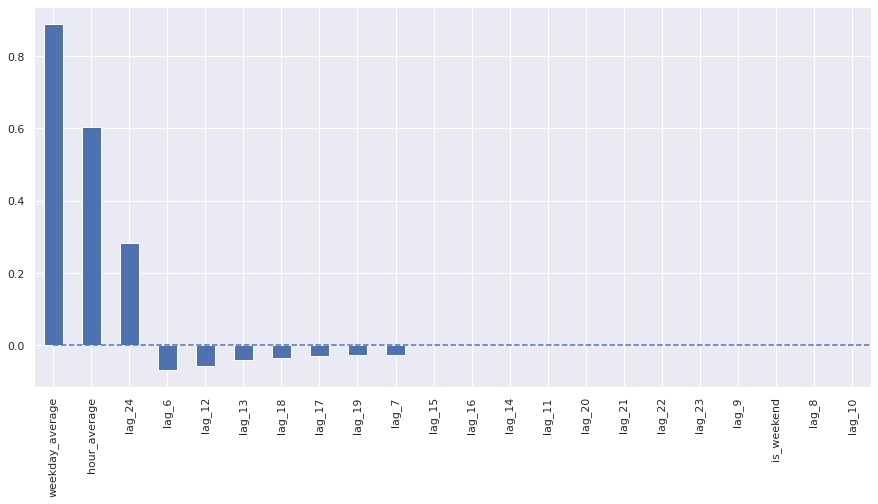

In [103]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Ласо регрессия оказалась чуть более удачной в отборе.

### Boosting

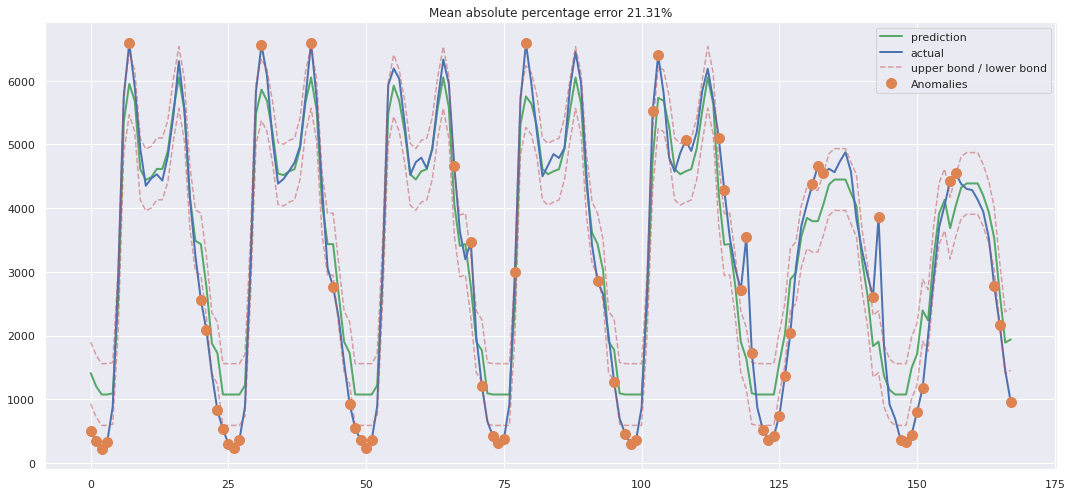

In [104]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

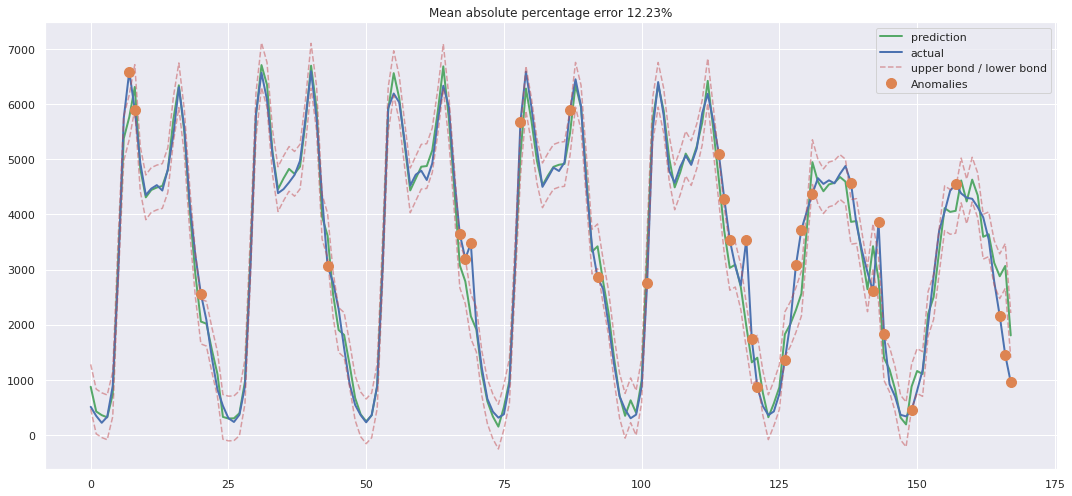

In [105]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test =\
prepareData(data_copy.traffic_volume, lag_start=6, lag_end=25, test_index=-24*7, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и отдельно - очищенный ряд, а потом сложить вместе предсказания.

### Facebook Prophet - automating routines

https://habrahabr.ru/company/ods/blog/323730/

In [106]:
from fbprophet import Prophet

In [107]:
# number of future predictions
predictions = 168

In [108]:
df = df_traffic_features['2018-07-24':]
df = df.reset_index()
for i in ['holiday', 'temp']:
    df = df.drop([i], axis=1)
df.columns = ['ds', 'y']

In [109]:
df.head()

,ds,y
0,2018-07-24 00:00:00,638.0
1,2018-07-24 01:00:00,391.0
2,2018-07-24 02:00:00,297.0
3,2018-07-24 03:00:00,390.0
4,2018-07-24 04:00:00,891.0


In [110]:
# reserve some data for testing
train_df = df[:-predictions-1]

In [111]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

,ds
1650,2018-09-30 18:00:00
1651,2018-09-30 19:00:00
1652,2018-09-30 20:00:00
1653,2018-09-30 21:00:00
1654,2018-09-30 22:00:00


In [112]:
# finally, making predictions
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1650,2018-09-30 18:00:00,3321.286983,2978.156620,4959.502570,3320.171704,3322.382737,650.077327,650.077327,650.077327,1133.135514,1133.135514,1133.135514,-483.058187,-483.058187,-483.058187,0.0,0.0,0.0,3971.364310
1651,2018-09-30 19:00:00,3321.221661,2231.589463,4180.112284,3320.088964,3322.333739,-83.796405,-83.796405,-83.796405,366.908613,366.908613,366.908613,-450.705017,-450.705017,-450.705017,0.0,0.0,0.0,3237.425256
1652,2018-09-30 20:00:00,3321.156339,1512.987579,3533.644511,3320.010777,3322.286667,-770.434953,-770.434953,-770.434953,-352.373264,-352.373264,-352.373264,-418.061689,-418.061689,-418.061689,0.0,0.0,0.0,2550.721385
1653,2018-09-30 21:00:00,3321.091016,1023.566056,2975.729136,3319.927860,3322.238823,-1262.810220,-1262.810220,-1262.810220,-877.481530,-877.481530,-877.481530,-385.328691,-385.328691,-385.328691,0.0,0.0,0.0,2058.280796
1654,2018-09-30 22:00:00,3321.025694,757.665481,2644.011379,3319.853201,3322.191956,-1598.196268,-1598.196268,-1598.196268,-1245.497342,-1245.497342,-1245.497342,-352.698926,-352.698926,-352.698926,0.0,0.0,0.0,1722.829426


Mean absolute percentage error 48.68%


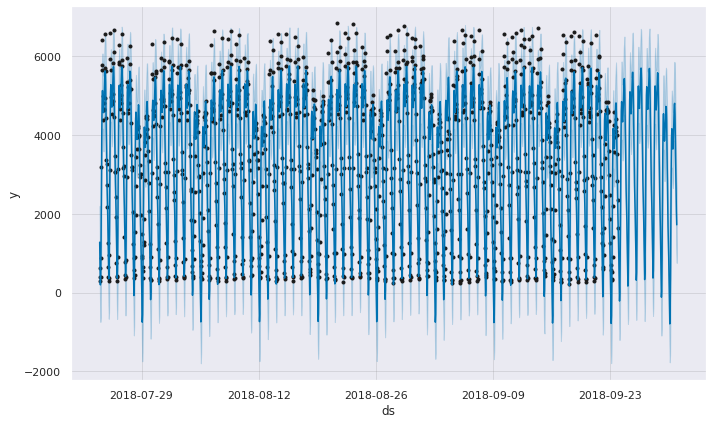

In [113]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

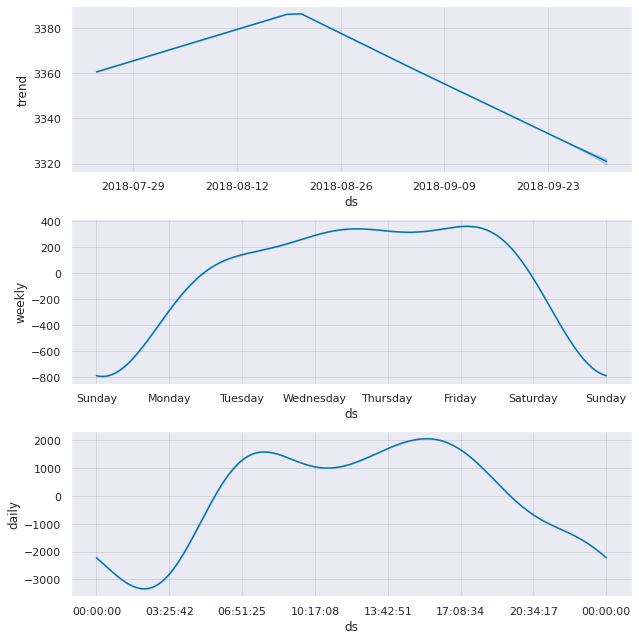

In [114]:
_ = model.plot_components(forecast)

Полезна для прототипирования или маркетинговых иследований, для понимания взлетит , не взлетит. Точность ниже, чем у остальных

Amazon GluonTS - new big player on the market

Попробуем построить модель. GluonTS предоставляет верхнеуровневую абстрацию Dataset, которая переводит разнородные форматы данных в один, удобный для последующей работы моделей. В частности, ListDataset переводит данные в список словарей, где отдельно записаны значения ряда и таймстэмпы. Для создания такого датасета мы передаём наш исходный временной ряд, указываем его частоту (в данном случае у нас почасовые данные, поэтому частота "H"), а также точку, до которой наш ряд будет отнесён к тренировочной выборке:

In [121]:
df = df_traffic_features['2018-07-24':].copy()
for i in ['holiday', 'temp']:
    df = df.drop([i], axis=1)

In [122]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.traffic_volume[:"2018-09-24"]}],
    freq = "H"
)

Посмотрим, в какой формат преобразовались данные:

In [123]:
training_data.list_data

[{'start': Timestamp('2018-07-24 00:00:00', freq='H'),
  'target': 2018-07-24 00:00:00     638.0
  2018-07-24 01:00:00     391.0
  2018-07-24 02:00:00     297.0
  2018-07-24 03:00:00     390.0
  2018-07-24 04:00:00     891.0
                          ...  
  2018-09-24 19:00:00    3253.0
  2018-09-24 20:00:00    2559.0
  2018-09-24 21:00:00    2084.0
  2018-09-24 22:00:00    1392.0
  2018-09-24 23:00:00     826.0
  Freq: H, Name: traffic_volume, Length: 1512, dtype: float64}]

Обучаем модель

In [124]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="H", 
    prediction_length=168, 
    trainer=Trainer(epochs=10)
)
predictor = estimator.train(training_data=training_data)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████| 50/50 [00:17<00:00,  2.86it/s, epoch=1/10, avg_epoch_loss=8.39]
INFO:gluonts.trainer:Epoch[0] Elapsed time 17.485 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=8.394248
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.28it/s, epoch=2/10, avg_epoch_loss=7.29]
INFO:gluonts.trainer:Epoch[1] Elapsed time 15.250 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=7.292557
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.05it/s, epoch=3/10, avg_epoch_loss=7.02]
INFO:gluonts.trainer:Epoch[2] Elapsed time 16.419 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=7.018354
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.20it/s, epoch=4/10, avg_epoch_loss=6.88]
INFO:gluonts.trainer:Epoch[3] Elapsed time 15.641 seconds
I

In [119]:
df.index[0]

Timestamp('2018-07-24 00:00:00', freq='H')

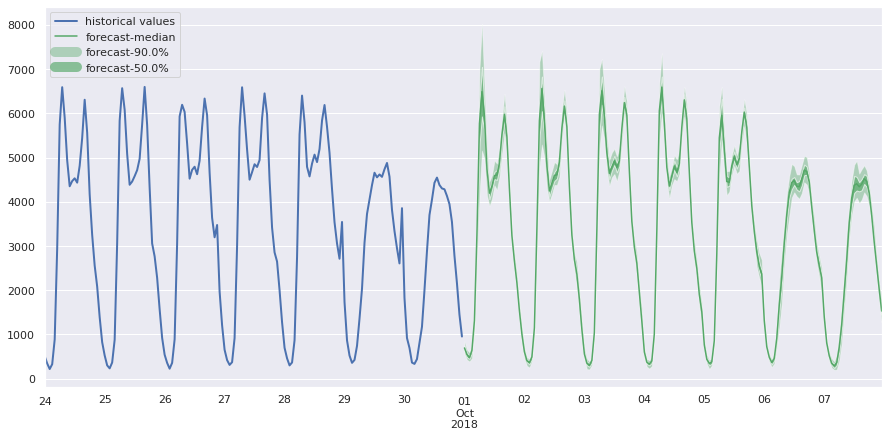

In [125]:
from gluonts.dataset.util import to_pandas

df = df_traffic_features['2018-09-24':].copy()
for i in ['holiday', 'temp']:
    df = df.drop([i], axis=1)

test_data = ListDataset(
    [{"start": df.index[0], "target": df.traffic_volume["2018-09-24":]}],
    freq = "H"
)

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(15, 7), label="historical values")
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')

В результате мы получили очень правдоподобный прогноз, который учитывает и недельную сезонность и 30-дневную цикличность. Хорошо видно, что доверительные интервалы прогноза расширяются в момент пика, где исторические значения были наименее стабильными, и сужаются в обычные дни, где дисперсия исторических данных была не такой большой.

GluonTS - очень удобный инструмент, который позволяет максимально быстро и верхнеуровнево получить вероятностую модель временного ряда, используя глубокое обучение под капотом. Помимо хороших результатов, которые получаются прямо из коробки, GluonTS можно тонко настраивать под любые нужды